<br><H3>Feature: Building a Classification model for Film Makers to Analyze the Sentiment of the People for their Movie through Movie reviews</H3></br>
<br></br>
<H4>Author: Ronak Dedhia
<br></br>
Version: 1.0
<br></br>
Date: 06 October, 2018
<br></br><br>
Description:</H4>
The project involves going through the 7 basic steps to building a Classification model<br>
Step 1: Collecting Movie reviews input as individual text files and combining them into 2 lists based on the sentiment - Train and Test <br>
Step 2: Exploratory Data Analysis to check if the distribution of comments is even in Test and Train datsets <br>
Step 3: Outlier Treatment to better understand the dataset <br>
Step 4: Perform Vectorization - To convert text into one large matrix of unique words with their importance scores. This matrix with scores will be used as features of the model <br>
Step 5: Train the classifier using Logistic Regression package (Check for max. accuracy by changing hyperparameter)
Step 6: Testing the model on test data and Evaluating it using Confusion matrix and ROC curve <br>
Step 7: Knowing the Top 5 Positive and Negitive words used by People in their reviews  
<br></br>


In [87]:
import sys
!{sys.executable} -m pip install --upgrade setuptools
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install operator
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip insall numpy
!{sys.executable} -m pip install tarfile

In [112]:
#import required packages
import tarfile
import os
import nltk
import string
import sklearn
from sklearn import metrics
import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
%matplotlib inline

<H3> Step 1: Extracting all the files in the movie_ratings compressed zip file (Do not run again) </H3>

tar = tarfile.open("D:\\CMU Academic\\4. Python\\Final Project Movie\\movie_ratings.tar.gz")<br>
tar.extractall() <br>
tar.close()  <br>
<H4>#get list of directory names and change the folder name in python from aclImdb to movie_data</H4>
if('aclImdb' in os.listdir(os.getcwd())):<br>
    os.rename('aclImdb', 'movie_data')<br>
print(os.listdir(os.getcwd()))

In [91]:
# The extension to search for
exten = '.txt'

topdir = 'D:\\CMU Academic\\4. Python\\Final Project Movie\\Feature 2\\movie_data\\test\\neg'
os.chdir(topdir)
output_path = 'full_test_neg.txt'
for dirpath, dirnames, files in os.walk(topdir):
    with open(output_path, 'w', encoding='utf8') as outfile:
        for name in files:
            if (name == output_path):
                continue
            if name.lower().endswith(exten):
                    with open(name, encoding = 'utf8') as infile:
                        outfile.write(infile.read()+ '\n')
                        
topdir = 'D:\\CMU Academic\\4. Python\\Final Project Movie\\Feature 2\\movie_data\\test\\pos'
os.chdir(topdir)
output_path = 'full_test_pos.txt'
for dirpath, dirnames, files in os.walk(topdir):
    with open(output_path, 'w', encoding='utf8') as outfile:
        for name in files:
            if (name == output_path):
                continue
            if name.lower().endswith(exten):
                    with open(name, encoding = 'utf8') as infile:
                        outfile.write(infile.read()+ '\n')

topdir = 'D:\\CMU Academic\\4. Python\\Final Project Movie\\Feature 2\\movie_data\\train\\neg'
os.chdir(topdir)
output_path = 'full_train_neg.txt'
for dirpath, dirnames, files in os.walk(topdir):
    with open(output_path, 'w', encoding='utf8') as outfile:
        for name in files:
            if (name == output_path):
                continue
            if name.lower().endswith(exten):
                    with open(name, encoding = 'utf8') as infile:
                        outfile.write(infile.read()+ '\n')
                        
topdir = 'D:\\CMU Academic\\4. Python\\Final Project Movie\\Feature 2\\movie_data\\train\\pos'
os.chdir(topdir)
output_path = 'full_train_pos.txt'
for dirpath, dirnames, files in os.walk(topdir):
    with open(output_path, 'w', encoding='utf8') as outfile:
        for name in files:
            if (name == output_path):
                continue
            if name.lower().endswith(exten):
                    with open(name, encoding = 'utf8') as infile:
                        outfile.write(infile.read()+ '\n')

In [92]:
#Appending all training comments into a list
reviews_train = []
for line in open('D:/CMU Academic/4. Python/Final Project Movie/Feature 2/movie_data/train/neg/full_train_neg.txt', 
                 'r', encoding='utf8'):
    reviews_train.append(line.strip())
for line in open('D:/CMU Academic/4. Python/Final Project Movie/Feature 2/movie_data/train/pos/full_train_pos.txt', 
                 'r', encoding='utf8'):
    reviews_train.append(line.strip())
    
reviews_test = []
for line in open('D:/CMU Academic/4. Python/Final Project Movie/Feature 2/movie_data/test/neg/full_test_neg.txt', 
                 'r', encoding='utf8'):
    reviews_test.append(line.strip())
for line in open('D:/CMU Academic/4. Python/Final Project Movie/Feature 2/movie_data/test/pos/full_test_pos.txt', 
                 'r', encoding='utf8'):
    reviews_test.append(line.strip())


In [93]:
reviews_test[0]

"Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in."

<H3> Text Filtering using Regex </H3>

In [94]:

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")

REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)") #Accounts for multiple space and - and / as seperates the words

def preprocess_reviews(reviews):
    reviews = [line.lower() for line in reviews]       #MAking all words lowercase
    reviews = [REPLACE_NO_SPACE.sub("", line) for line in reviews]    #Substituting with nulls
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews] # Substitutes with single space
    
    return reviews

reviews_train_clean = preprocess_reviews(reviews_train)
reviews_test_clean = preprocess_reviews(reviews_test)

<H3> Step 2: Exploratory Data Analysis of Movie Reviews </H3>

In [95]:

#Create 4 different dataframes for each train and test
combine_neg_train = pd.DataFrame({ 'Type': 'Negative_Train','Comments': reviews_train_clean[:12501]}) 
combine_pos_train = pd.DataFrame({ 'Type': 'Positive_Train','Comments': reviews_train_clean[12501:]})
combine_neg_test = pd.DataFrame({ 'Type': 'Negative_Test','Comments': reviews_test_clean[:12501]})
combine_pos_test = pd.DataFrame({ 'Type': 'Positive_Test','Comments': reviews_test_clean[12501:]})

def calculate_words(row):
    return len(row.split())
                                     
combine_all = pd.concat([combine_neg_train, combine_pos_train, combine_neg_test, combine_pos_test])
combine_all['Comments_length'] = combine_all['Comments'].apply(calculate_words)

<H3> Step 3: Outlier Treatment & Data Cleaning</H3>
Note 99 Percentile of the comments lie in the length of about 900 words so delete the outlier comments

In [96]:
combine_all.Comments_length.describe() 
print(combine_all.quantile(0.99)) # Most of the reviews are within 904 words limit

combine_all = combine_all[combine_all < 904]

Comments_length    904.0
Name: 0.99, dtype: float64


<H3> Analyze Plots to see Equal Distribution of Comments in Positive and Negative </H3>
We see that the length of comments for positive and negative in Train dataset is equally spread out which will lead to
better fit of the model

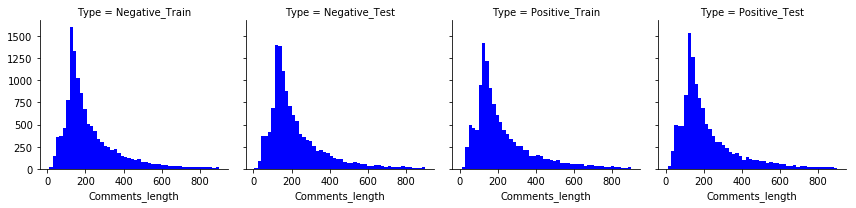

In [97]:
#Plotting the ditribution of lengths in all 4 categories of comments that we have split
g = sns.FacetGrid(data=combine_all, col='Type', col_order= ['Negative_Train', 'Negative_Test', 
                                                            'Positive_Train', 'Positive_Test'], aspect=1)
g.map(plt.hist, 'Comments_length', bins=50, color = 'b')

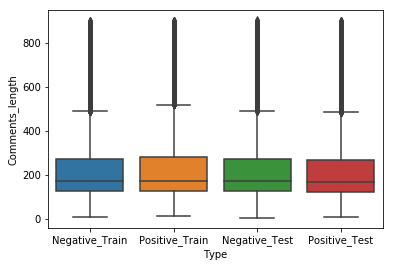

In [98]:
sns.boxplot(x='Type', y='Comments_length', data=combine_all)

<H3> Step 4: Perform Vectorization - Simplest form for Classification </H3>

In [99]:
from sklearn.feature_extraction.text import CountVectorizer

#Get score for the occurence of each unique word in the training dataset to know its importance as a feature
cv = CountVectorizer(binary=True, stop_words= 'english')
cv.fit(reviews_train_clean)
X = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)

<H3>Step 5: Build Classifier using Logistic Regression based on training data </H3>

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#Create a target predictor series for positive and negative
target = []
for i in range(25000):
    if i > 12500:        #Since equal number of positive and negative in test and train file
        target.append(1)
    else: target.append(0)

X_train, X_val, y_train, y_val = train_test_split( X, target, train_size = 0.75)

#Trying different models by changing the hyperparameter c which adjusts the regularization
variable_c = [0.01, 0.05, 0.25, 0.5, 1]
for c in variable_c:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    accuracy = accuracy_score(y_val, lr.predict(X_val))
    print ("Accuracy for C={0}: {1}".format(c, accuracy))
    
#         Accuracy for C=0.01: 0.87568
#         Accuracy for C=0.05: 0.88496
#         Accuracy for C=0.25: 0.88336
#         Accuracy for C=0.5: 0.87904
#         Accuracy for C=1: 0.87472

c:\users\ronak\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
c:\users\ronak\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.87568
Accuracy for C=0.05: 0.88256
Accuracy for C=0.25: 0.87968
Accuracy for C=0.5: 0.8752
Accuracy for C=1: 0.872


<H3> Step 6: Testing the Reviews in Test Dataset using model with C = 0.05 as it gives highest training accuracy of 87.76% </H3>

In [119]:
final_model = LogisticRegression(C=0.05)
final_model.fit(X, target)
prediction = final_model.predict(X_test)

accuracy_score = accuracy_score(target, prediction)  #Target can be used as same number of positive and negative comments taken in test and train
print ("Final Accuracy: {0}".format(accuracy_score))
# Final Accuracy: 0.87764

c:\users\ronak\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Final Accuracy: 0.87764


<H3> Evaluating the Model using Confusion Matrix </H3>

In [126]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(target, prediction))
print('\n')
print(classification_report(target, prediction))

[[10899  1602]
 [ 1457 11042]]


              precision    recall  f1-score   support

           0       0.88      0.87      0.88     12501
           1       0.87      0.88      0.88     12499

   micro avg       0.88      0.88      0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



<H3> Plotting the AUC and ROC plot to visualize the accuracy

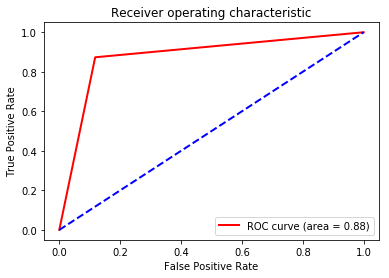

In [132]:
#Computing false and true positive rates
fpr, tpr, thresholds = sklearn.metrics.roc_curve(prediction, target, drop_intermediate=False)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.figure()
#Adding the ROC
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = {0:.2f})'.format(roc_auc))
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

<H3> Correct Prediction of a Negative Review </H3> 
Note: Though it may predict many of them as positive if strong sentiments are not conveyed

In [105]:
negative_review_test = ["Even though it is a spoof, the film is often tediously exaggerated and downright silly, \
                        relying on sheer buffoonery to get the narrative moving."]
negative_review_transform = cv.transform(negative_review_test)

prediction = final_model.predict(negative_review_transform)
if(prediction[0] == 0):
    print('Negative Sentiment')
else: print('Positive Sentiment')

Negative Sentiment


<H3> Step 7: Knowing the Top 5 Good and Bad words used to classify a review as Negative or Positive Review </H3>

In [107]:
coefs=final_model.coef_[0]
top_five = np.argpartition(coefs, -5)[-5:]
print(top_five)

#Mapping the array indexes in final_model to the cv_features
feature_map = list(zip(cv.get_feature_names(), final_model.coef_[0]))

feature_to_coef = {
    word: coef for word, coef in feature_map
}


[29672  3998 35332 61278 28265]


In [108]:
import operator

#Sort the dictionary to get the top five
sorted_feature = sorted(feature_to_coef.items(), key=operator.itemgetter(1), reverse= True)

In [109]:

print("Positive Best Words")
for best_positive in sorted_feature[:5]:
    print (best_positive)
    
#Print the last five features in the dictionary for top Negative words
print("\nNegative Best words")
for best_negative in sorted_feature[-5:]:
    print (best_negative)
    
#     Positive Best Words
# ('excellent', 0.9473684379032968)
# ('perfect', 0.7811572191782752)
# ('great', 0.6845852871870285)
# ('amazing', 0.6701766735187026)
# ('favorite', 0.6660101910929823)

# Negative Best words
# ('disappointment', -0.8879549193353439)
# ('poorly', -0.8977919184670279)
# ('awful', -1.0583522352122747)
# ('waste', -1.2272920144231492)
# ('worst', -1.3595203746666376)

Positive Best Words
('excellent', 0.9473684379032968)
('perfect', 0.7811572191782752)
('great', 0.6845852871870285)
('amazing', 0.6701766735187026)
('favorite', 0.6660101910929823)

Negative Best words
('disappointment', -0.8879549193353439)
('poorly', -0.8977919184670279)
('awful', -1.0583522352122747)
('waste', -1.2272920144231492)
('worst', -1.3595203746666376)
